/var/folders/gn/p2223k714bz4fr9y200f1jpw0000gn/T/ipykernel_51418/2720965202.py:10: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('accepted_2007_to_2018Q4.csv')


CV ROC AUC: 0.6991093300917255
Accuracy: 0.6484328238911174
F1 Score: 0.4171561346309114
ROC AUC: 0.697069684933168
Confusion Matrix: [[140578  75029]
 [ 19538  33842]]


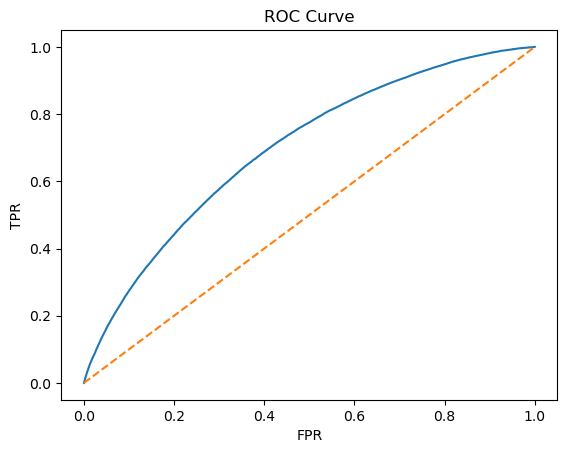

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

data = pd.read_csv('accepted_2007_to_2018Q4.csv')

data = data.dropna(subset=['loan_status'])
data = data[data['loan_status'].isin(['Fully Paid', 'Charged Off'])]
data['loan_status'] = data['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})

features = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'fico_range_low', 'inq_last_6mths', 'grade']
data = data[features + ['loan_status']].dropna()

le = LabelEncoder()
data['grade'] = le.fit_transform(data['grade'])

scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

X = data.drop('loan_status', axis=1)
y = data['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_sm, y_train_sm)

cv_scores = cross_val_score(model, X_train_sm, y_train_sm, cv=5, scoring='roc_auc')
print(f'CV ROC AUC: {np.mean(cv_scores)}')

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {acc}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc}')
print('Confusion Matrix:', cm)

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], '--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.show()

In [2]:
# === RANDOM FOREST ===
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_leaf=5,
    class_weight='balanced',      # helps with remaining imbalance
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_sm, y_train_sm)

# Predictions
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Metrics
print("=== Random Forest ===")
print(f"Accuracy : {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score : {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC  : {roc_auc_score(y_test, y_prob_rf):.4f}")

# Feature importance (top 10)
importances_rf = pd.Series(rf.feature_importances_, index=X_train.columns)
print("\nTop 10 important features (Random Forest)")
print(importances_rf.sort_values(ascending=False).head(10))

=== Random Forest ===
Accuracy : 0.6726
F1-Score : 0.4140
ROC-AUC  : 0.6963

Top 10 important features (Random Forest)
int_rate          0.324677
grade             0.214458
fico_range_low    0.195342
loan_amnt         0.079620
annual_inc        0.076012
dti               0.051441
installment       0.049085
inq_last_6mths    0.009365
dtype: float64


In [4]:
# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
print('Confusion Matrix (Random Forest):', cm_rf)

Confusion Matrix (Random Forest): [[149798  65809]
 [ 22268  31112]]


In [3]:
### === XGBOOST ===
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight = (len(y_train_sm) - sum(y_train_sm)) / sum(y_train_sm),  # handles imbalance
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb.fit(X_train_sm, y_train_sm)

# Predictions
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

# Metrics
print("=== XGBoost ===")
print(f"Accuracy : {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"F1-Score : {f1_score(y_test, y_pred_xgb):.4f}")
print(f"ROC-AUC  : {roc_auc_score(y_test, y_prob_xgb):.4f}")

# Feature importance (top 10)
importances_xgb = pd.Series(xgb.feature_importances_, index=X_train.columns)
print("\nTop 10 important features (XGBoost)")
print(importances_xgb.sort_values(ascending=False).head(10))

=== XGBoost ===
Accuracy : 0.7459
F1-Score : 0.3358
ROC-AUC  : 0.6740

Top 10 important features (XGBoost)
grade             0.360733
fico_range_low    0.339256
int_rate          0.123184
annual_inc        0.086232
loan_amnt         0.055883
installment       0.014716
dti               0.012252
inq_last_6mths    0.007743
dtype: float32


In [5]:
# Confusion Matrix for XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print('Confusion Matrix (XGBoost):', cm_xgb)

Confusion Matrix (XGBoost): [[183342  32265]
 [ 36098  17282]]
